In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib
import lightgbm as lgb


Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [7]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,...,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [8]:
# print('split path-timestamp in 2 columns')
# data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
# print('remove path-timestamp column')
# data.drop('path-timestamp', axis=1,inplace=True)

In [9]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [10]:
unpaths=data.path.unique()

In [11]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


### CV TRAIN

In [12]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 11,
    "num_leaves": 256,  
    "max_bin": 256,
    "num_iterations": 15000
}


In [13]:
# CROSS VALIDATION

name='lgbm'+version


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]

all_preds=[]
all_targets=[]

np.random.seed(42)
sh=np.random.permutation(unpaths)


k=5
val_size=int(len(sh)/k)
for f in range(k):
    print('fold:', f)

    if f<(k-1):
        val_paths=sh[val_size*f:val_size*(f+1)]
    else:
        val_paths=sh[val_size*f:]

    train_paths=[x for x in unpaths if x not in val_paths]
    
    val_paths=np.array(val_paths)
    train_paths=np.array(train_paths)
    
    X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

    y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

    X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
    y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

    val_predsXY=[]
    for i in range(2):
        y_train = y_trainXY[:,i]
        y_val = y_valXY[:,i]

        gbm = lgb.LGBMRegressor(**hyper_params)
        model = gbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='l1',
            verbose=100,
            early_stopping_rounds=200)
        
        joblib.dump(model, weights_path+'fold_'+str(f)+['x','y'][i]+'_v2')
        
        val_predsXY.append(gbm.predict(X_val, num_iteration=gbm.best_iteration_) )
    val_predsXY=np.stack(val_predsXY).T
    
    print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

    all_preds.append(val_predsXY)
    all_targets.append(y_valXY)
        

all_predsV=np.vstack(all_preds)
all_targetsV=np.vstack(all_targets)    

fold: 0
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 4.70892	training's l2: 38.4149	valid_1's l1: 4.74241	valid_1's l2: 39.9619
[200]	training's l1: 3.11367	training's l2: 16.1914	valid_1's l1: 3.23712	valid_1's l2: 18.0997
[300]	training's l1: 2.1492	training's l2: 7.58485	valid_1's l1: 2.38147	valid_1's l2: 9.75665
[400]	training's l1: 1.57569	training's l2: 4.15355	valid_1's l1: 1.90686	valid_1's l2: 6.55392
[500]	training's l1: 1.25008	training's l2: 2.71673	valid_1's l1: 1.66096	valid_1's l2: 5.28815
[600]	training's l1: 1.06446	training's l2: 2.05617	valid_1's l1: 1.53985	valid_1's l2: 4.77474
[700]	training's l1: 0.958898	training's l2: 1.7168	valid_1's l1: 1.48041	valid_1's l2: 4.5559
[800]	training's l1: 0.897002	training's l2: 1.52743	valid_1's l1: 1.45335	valid_1's l2: 4.46053
[900]	training's l1: 0.856996	training's l2: 1.4045	valid_1's l1: 1.44027	valid_1's l2: 4.4087
[1000]	training's l1: 0.828916	training's l2: 1.32064	valid_1's l1:

In [ ]:
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

mean validation error, 5-fold 1.9529932224674111


In [ ]:
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

mean validation error, 5-fold 1.9529932224674111


In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV.csv.gz', index=False, compression='gzip')

In [ ]:
'/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz'

'/gdrive/My Drive/Colab Notebooks/forPdata423KNeighbors_oof.csv.gz'

## EVALUATION - PLOTS

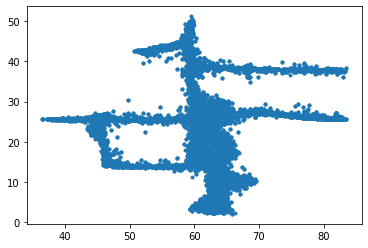

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

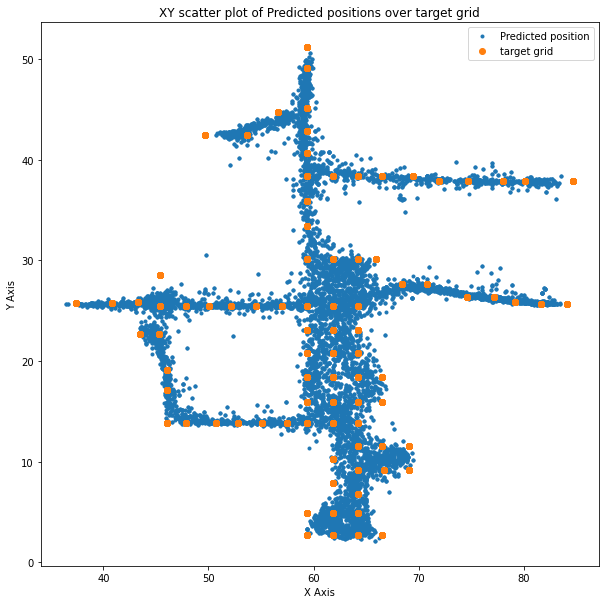

mean validation error, 5-fold 1.9529932224674111


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
name='lgbm'+version
all_predsV=pd.read_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz').values
all_predsV.shape

(14373, 2)

In [ ]:

unpaths=data.path.unique()
np.random.seed(42)
sh=np.random.permutation(unpaths)
indexes=[]
k=5
val_size=int(len(sh)/k)
for f in range(k):
    # print('fold:', f)

    if f<(k-1):
        val_paths=sh[val_size*f:val_size*(f+1)]
    else:
        val_paths=sh[val_size*f:]

    X_val = data.loc[data.path.isin(val_paths), : ]
    indexes.extend(np.array(X_val.index).tolist())
data=data.iloc[indexes,:].reset_index()    

In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
np.mean(scoreperrow), np.std(scoreperrow)

(1.9529932224674111, 1.5347026404174788)

In [ ]:
all_targetsV = data.loc[:, ['x', 'y'] ].values

In [ ]:
unpaths=data.path.unique()

In [ ]:
unpaths[11] # 'record_2021_11_01_07_35_09'

'record_2021_11_01_07_35_09'

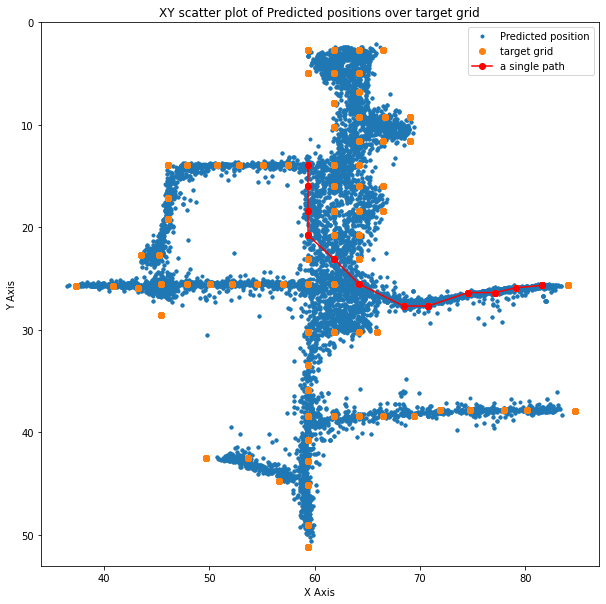

mean validation error, 5-fold 1.9529932224674111


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.plot(all_targetsV[data.path==unpaths[11],0],all_targetsV[data.path==unpaths[11],1],'o-', label='a single path', color='r')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.axis([34, 87, 53, 0])
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# name='lgbm'+version
# all_predsV=pd.read_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz').values
# # CROSS VALIDATION

# name='lgbm'+version


# score_df = pd.DataFrame()
# oof = list()
# predictions = list()

# oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
# preds_x, preds_y = 0, 0

# scores_per_fold=[]

# all_targets=[]

# np.random.seed(42)
# sh=np.random.permutation(unpaths)


# k=5
# val_size=int(len(sh)/k)
# for f in range(k):
#     print('fold:', f)

#     if f<(k-1):
#         val_paths=sh[val_size*f:val_size*(f+1)]
#     else:
#         val_paths=sh[val_size*f:]

#     val_paths=np.array(val_paths)
    
#     y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


#     all_targets.append(y_valXY)
        
# all_targetsV=np.vstack(all_targets)    

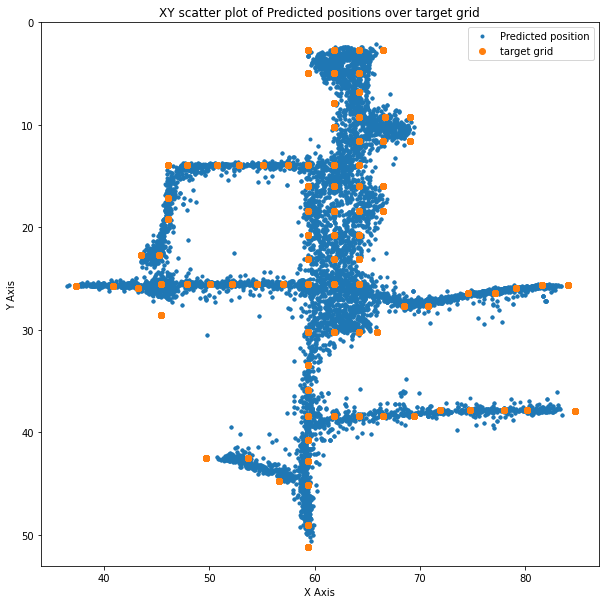

mean validation error, 5-fold 1.9529932224674111


In [ ]:
# # Reverse Y axis in Plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,10))
# plt.title('XY scatter plot of Predicted positions over target grid')
# plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
# plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')

# plt.axis([34, 87, 53, 0])


# plt.legend()
# plt.xlabel('X Axis')
# plt.ylabel('Y Axis')
# plt.show()
# print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
version

'forPdata423'

## Full train

In [ ]:
hyper_params["num_iterations"]= 2500

In [ ]:


name=version+'lgbm'

train_paths=unpaths[:]

train_paths=np.array(train_paths)

X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

train_predsXY=[]
all_train_targets=[]
xy=['x', 'y']
for i in range(2):
    y_train = y_trainXY[:,i]

    gbm = lgb.LGBMRegressor(**hyper_params)


    model = gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='l1',
        verbose=100
        )
    
    # joblib.dump(model, weights_path+'FullTrain_'+['x','y'][i])
    joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model'+xy[i])

    train_predsXY.append(gbm.predict(X_train, num_iteration=gbm.best_iteration_) )

train_predsXY=np.stack(train_predsXY).T

print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


[100]	training's l2: 38.6404	training's l1: 4.71413
[200]	training's l2: 16.3846	training's l1: 3.13195
[300]	training's l2: 7.73876	training's l1: 2.17225
[400]	training's l2: 4.28738	training's l1: 1.60209
[500]	training's l2: 2.84385	training's l1: 1.27744
[600]	training's l2: 2.17821	training's l1: 1.09273
[700]	training's l2: 1.83943	training's l1: 0.988542
[800]	training's l2: 1.64866	training's l1: 0.925964
[900]	training's l2: 1.52786	training's l1: 0.885956
[1000]	training's l2: 1.44287	training's l1: 0.85753
[1100]	training's l2: 1.38558	training's l1: 0.838701
[1200]	training's l2: 1.34455	training's l1: 0.825214
[1300]	training's l2: 1.31137	training's l1: 0.813841
[1400]	training's l2: 1.28411	training's l1: 0.804944
[1500]	training's l2: 1.25997	training's l1: 0.796975
[1600]	training's l2: 1.23931	training's l1: 0.790197
[1700]	training's l2: 1.22215	training's l1: 0.784476
[1800]	training's l2: 1.20588	training's l1: 0.779151
[1900]	training's l2: 1.18889	training's l1:

In [ ]:
# print('Save LightGBM model fully trained')
# joblib.dump(model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')

Save LightGBM model fully trained


['/gdrive/My Drive/Colab Notebooks/weights/forPdata423KNeighbors_model']